In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Add this at the beginning of main()
import os
import shutil

# Copy dataset from Google Drive to local storage
local_data_path = '/content/digits'
if not os.path.exists(local_data_path):
    shutil.copytree('/content/drive/MyDrive/Dataset/digits', local_data_path)

# Copy dataset from Google Drive to local storage
local_data_path = '/content/letters'
if not os.path.exists(local_data_path):
    shutil.copytree('/content/drive/MyDrive/Dataset/letters', local_data_path)

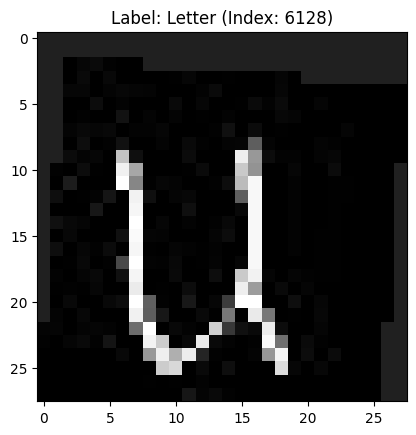

In [148]:
import torch
import random
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import os

# Custom transformation to add Salt-and-Pepper noise
class AddSaltPepperNoise:
    def __init__(self, salt_prob=0.01, pepper_prob=0.01):
        self.salt_prob = salt_prob    # Probability of salt noise (white pixels)
        self.pepper_prob = pepper_prob  # Probability of pepper noise (black pixels)

    def __call__(self, tensor):
        # Convert tensor to numpy for easier manipulation
        img = tensor.numpy()

        # Create a noise mask
        noise = np.random.random(img.shape)

        # Add salt noise (white pixels)
        img[noise < self.salt_prob] = 1.0

        # Add pepper noise (black pixels)
        img[noise > (1 - self.pepper_prob)] = 0.0

        return torch.from_numpy(img)

    def __repr__(self):
        return self.__class__.__name__ + '(salt_prob={0}, pepper_prob={1})'.format(self.salt_prob, self.pepper_prob)

# Define the augmentation pipeline with Salt-and-Pepper noise
transform = transforms.Compose([
    transforms.Grayscale(),  # Convert to grayscale if your images aren't already
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.1307,), (0.3081,)),  # Normalize (using MNIST stats)
    transforms.RandomAffine(degrees=(-5,5), translate=(0.1, 0.1), scale=(0.9, 1.1), shear=3),  # Random affine
    transforms.RandomApply([transforms.ColorJitter(brightness=0.1, contrast=0.1)], p=0.3),
    transforms.RandomApply([AddSaltPepperNoise(salt_prob=0.01, pepper_prob=0.01)], p=0.2)  # Add Salt-and-Pepper noise
])

# Custom Dataset class to assign "digit" (0) or "letter" (1) labels
class CustomImageFolder(Dataset):
    def __init__(self, root, transform=None, label=0):
        self.dataset = datasets.ImageFolder(root=root, transform=transform)
        self.label = label  # Fixed label for all images in this dataset (0 for digits, 1 for letters)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, _ = self.dataset[index]  # Get the image, ignore original label
        return image, self.label  # Return image with fixed label

# Load datasets from both folders
digits_path = '/content/digits'
letters_path = '/content/letters'

# Create custom datasets with fixed labels
digits_dataset = CustomImageFolder(root=digits_path, transform=transform, label=0)  # 0 for digits
letters_dataset = CustomImageFolder(root=letters_path, transform=transform, label=1)  # 1 for letters

# Combine the datasets into one
dataset = ConcatDataset([digits_dataset, letters_dataset])

# Get a random index
random_idx = random.randint(0, len(dataset) - 1)

# Retrieve a random image from the combined dataset
image, label = dataset[random_idx]

# Convert the tensor to a numpy array and remove the batch dimension
image = image * 0.3081 + 0.1307  # Reverse the normalization
image = image.squeeze().numpy()  # Remove channel dimension for grayscale

# Map label to string for display
label_str = "Digit" if label == 0 else "Letter"

# Display the image
plt.imshow(image, cmap='gray')
plt.title(f'Label: {label_str} (Index: {random_idx})')
plt.show()

Using random seed: 67675
Train Epoch: 1 [0/5760 (0%)]	Loss: 0.698134
Train Epoch: 1 [640/5760 (11%)]	Loss: 0.632508
Train Epoch: 1 [1280/5760 (22%)]	Loss: 0.496748
Train Epoch: 1 [1920/5760 (33%)]	Loss: 0.641249
Train Epoch: 1 [2560/5760 (44%)]	Loss: 0.463961
Train Epoch: 1 [3200/5760 (56%)]	Loss: 0.564315
Train Epoch: 1 [3840/5760 (67%)]	Loss: 0.574851
Train Epoch: 1 [4480/5760 (78%)]	Loss: 0.342568
Train Epoch: 1 [5120/5760 (89%)]	Loss: 0.458596

Test set: Average loss: 0.4268, Accuracy: 1165/1440 (81%)

Train Epoch: 2 [0/5760 (0%)]	Loss: 0.409726
Train Epoch: 2 [640/5760 (11%)]	Loss: 0.467783
Train Epoch: 2 [1280/5760 (22%)]	Loss: 0.291256
Train Epoch: 2 [1920/5760 (33%)]	Loss: 0.292891
Train Epoch: 2 [2560/5760 (44%)]	Loss: 0.350920
Train Epoch: 2 [3200/5760 (56%)]	Loss: 0.368285
Train Epoch: 2 [3840/5760 (67%)]	Loss: 0.359317
Train Epoch: 2 [4480/5760 (78%)]	Loss: 0.550734
Train Epoch: 2 [5120/5760 (89%)]	Loss: 0.314133

Test set: Average loss: 0.3394, Accuracy: 1279/1440 (89%)

M

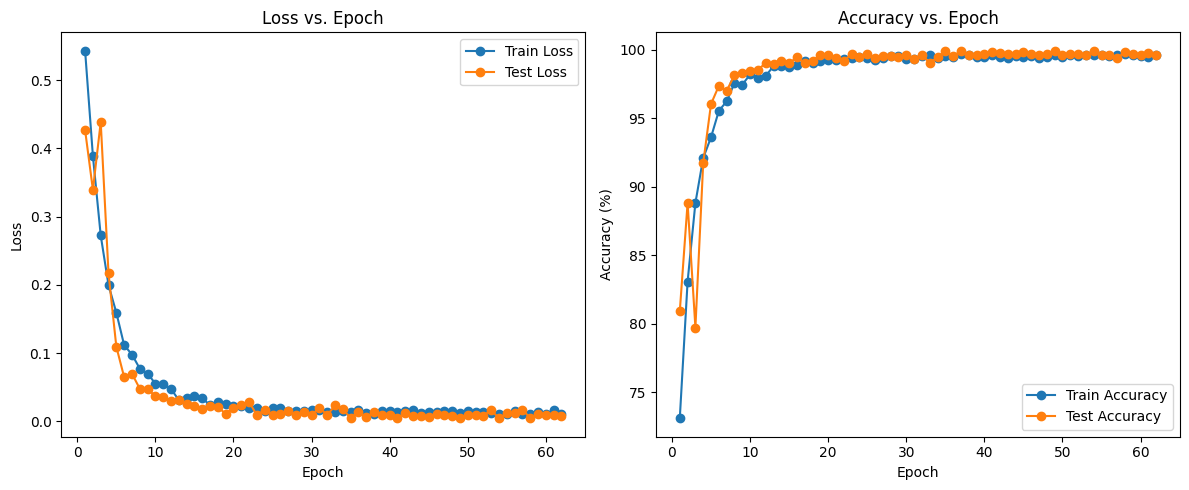

In [149]:
import os
import cv2
import sys
import time
import random
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset, random_split
from torch.optim.lr_scheduler import StepLR
from PIL import Image
import matplotlib.pyplot as plt
import shutil
from google.colab import files

# Neural Network for Binary Classification
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, 1)  # Input channels: 1, Output channels: 64
        self.conv2 = nn.Conv2d(64, 128, 3, 1)  # Output channels: 128
        self.conv3 = nn.Conv2d(128, 256, 3, 1)  # Third convolutional layer
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.4)
        self.fc1 = nn.Linear(256 * 5 * 5, 512)  # Adjusted for conv layers and input size
        self.fc2 = nn.Linear(512, 256)  # Additional fully connected layer
        self.fc3 = nn.Linear(256, 2)  # Output layer for 2 classes (digit or letter)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)  # Still using log_softmax for CrossEntropyLoss
        return output

# Custom transformation to add Salt-and-Pepper noise
class AddSaltPepperNoise:
    def __init__(self, salt_prob=0.01, pepper_prob=0.01):
        self.salt_prob = salt_prob
        self.pepper_prob = pepper_prob

    def __call__(self, tensor):
        img = tensor.numpy()
        noise = np.random.random(img.shape)
        img[noise < self.salt_prob] = 1.0
        img[noise > (1 - self.pepper_prob)] = 0.0
        return torch.from_numpy(img)

    def __repr__(self):
        return self.__class__.__name__ + '(salt_prob={0}, pepper_prob={1})'.format(self.salt_prob, self.pepper_prob)

# Custom Dataset class for binary labels
class CustomImageFolder(Dataset):
    def __init__(self, root, transform=None, label=0):
        self.dataset = datasets.ImageFolder(root=root, transform=transform)
        self.label = label  # Fixed label (0 for digits, 1 for letters)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, _ = self.dataset[index]  # Ignore original label
        return image, self.label

# Training Function
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)  # Negative log likelihood loss
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % args.log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    train_loss /= len(train_loader)
    accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss, accuracy

# Test Function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')
    return test_loss, accuracy

# Train and Evaluate
def train_and_evaluate(args, model, device, train_loader, test_loader, optimizer, scheduler):
    test_losses = []
    test_accuracies = []
    train_losses = []
    train_accuracies = []

    best_test_loss = float('inf')
    patience = 8
    no_improvement_count = 0

    model_dir = f"Binary_Model_seed_{args.seed}"
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    for epoch in range(1, args.epochs + 1):
        train_loss, train_accuracy = train(args, model, device, train_loader, optimizer, epoch)
        test_loss, test_accuracy = test(model, device, test_loader)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            no_improvement_count = 0
            if args.save_model and epoch > 1:
                model_filename = f"binary_cnn_epoch:{epoch}_test-accuracy:{test_accuracy:.4f}_test-loss:{test_loss:.4f}.pt"
                model_path = os.path.join(model_dir, model_filename)
                try:
                    torch.save(model.state_dict(), model_path)
                    print(f"Model saved with new best test loss: {best_test_loss:.4f} \n")
                except Exception as e:
                    print(f"Error saving model: {e}")
        else:
            no_improvement_count += 1

        if no_improvement_count >= patience:
            print(f"\nEarly stopping triggered after {epoch} epochs. No improvement in test loss for {patience} consecutive epochs.")
            break

        scheduler.step()

    return train_losses, train_accuracies, test_losses, test_accuracies

# Plot graphs
def plot_results(train_losses, train_accuracies, test_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'o-', label='Train Loss')
    plt.plot(epochs, test_losses, 'o-', label='Test Loss')
    plt.title('Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'o-', label='Train Accuracy')
    plt.plot(epochs, test_accuracies, 'o-', label='Test Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Main function
def main():
    random_seed = random.randint(0, 100000)
    print(f"Using random seed: {random_seed}")

    torch.manual_seed(random_seed)
    random.seed(random_seed)

    args = argparse.Namespace(
        batch_size=64,
        test_batch_size=128,
        epochs=500,
        lr=1,
        gamma=0.9,
        no_cuda=False,
        no_mps=False,
        dry_run=False,
        seed=random_seed,
        log_interval=10,
        save_model=True
    )

    use_cuda = not args.no_cuda and torch.cuda.is_available()
    use_mps = not args.no_mps and torch.backends.mps.is_available()

    torch.manual_seed(args.seed)

    if use_cuda:
        device = torch.device("cuda")
    elif use_mps:
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}

    if use_cuda:
        cuda_kwargs = {'num_workers': 1, 'pin_memory': True, 'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    # Data Loading with Augmentation for Training
    transform_train = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((28, 28)),  # Resize to 28x28
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.RandomAffine(degrees=(-5,5), translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.1, contrast=0.1)], p=0.3),
        transforms.RandomApply([AddSaltPepperNoise(salt_prob=0.01, pepper_prob=0.01)], p=0.2)
    ])

    # Transform for testing (no augmentation)
    transform_test = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Load custom datasets
    digits_path = '/content/digits'
    letters_path = '/content/letters'

    # Create custom datasets with binary labels
    digits_dataset = CustomImageFolder(root=digits_path, transform=transform_train, label=0)  # 0 for digits
    letters_dataset = CustomImageFolder(root=letters_path, transform=transform_train, label=1)  # 1 for letters

    # Combine datasets
    combined_dataset = ConcatDataset([digits_dataset, letters_dataset])

    # Split into 80% train and 20% test
    train_size = int(0.8 * len(combined_dataset))
    test_size = len(combined_dataset) - train_size
    train_dataset, test_dataset = random_split(combined_dataset, [train_size, test_size])

    # Apply test transform to the test dataset
    test_dataset.dataset.datasets[0].transform = transform_test  # Update digits transform
    test_dataset.dataset.datasets[1].transform = transform_test  # Update letters transform

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, **train_kwargs)
    test_loader = DataLoader(test_dataset, **test_kwargs)

    # Model and Optimizer Initialization
    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)
    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)

    # Train and Evaluate
    train_losses, train_accuracies, test_losses, test_accuracies = train_and_evaluate(args, model, device, train_loader, test_loader, optimizer, scheduler)

    # Plot Results
    plot_results(train_losses, train_accuracies, test_losses, test_accuracies)

if __name__ == '__main__':
    main()

In [150]:
model_path = '/content/Binary_Model_seed_67675'

# Compress the folder into a zip file
shutil.make_archive(model_path, 'zip', model_path)  # Use the same folder name

# Download the zip file in Google Colab
files.download('Binary_Model_seed_67675.zip')  # Download the zip file with the correct name

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>